# Kaggle - What's Cooking

The goal of this analysis is to determine the cuisine of a recipe based on its ingredients.  The data is in the form of a json file, where each element is a recipe with ingredients.  This is an NLP project so we'll be using ML techniques designed for language and text.

In [151]:
# Load modules

import json
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plot
import seaborn as sns; sns.set()
import unicodedata
import copy

from scipy.stats import describe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

%load_ext autoreload
%autoreload 2

pd.set_option('precision',3)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Exploration

In [13]:
# Load data

#with open('C:\\Users\\Colleen\\Documents\\Kaggle_Whats_Cooking\\data\\train.json', 'r') as f:
with open('/Users/colleensmith/Documents/Kaggle_Whats_Cooking/data/train.json', 'r') as f:
    train_data = json.load(f)
print 'Number of recipes: ' + str(len(train_data))

Number of recipes: 39774


The data is in the form of a list of dictionaries, containing the cuisine, an ID and the list of ingredients:

In [3]:
train_data[0]

{u'cuisine': u'greek',
 u'id': 10259,
 u'ingredients': [u'romaine lettuce',
  u'black olives',
  u'grape tomatoes',
  u'garlic',
  u'pepper',
  u'purple onion',
  u'seasoning',
  u'garbanzo beans',
  u'feta cheese crumbles']}

The distribution of cusine samples in the training set is shown below.  We have an unbalanced class situation, so we'll need to be aware of that when we assess accuracy of models.

In [141]:
counter = collections.Counter([x['cuisine'] for x in train_data])
cuisine_dist = pd.DataFrame({'cuisine': counter.keys(), 'count': counter.values()})
num_ing = [len(x['ingredients']) for x in train_data]

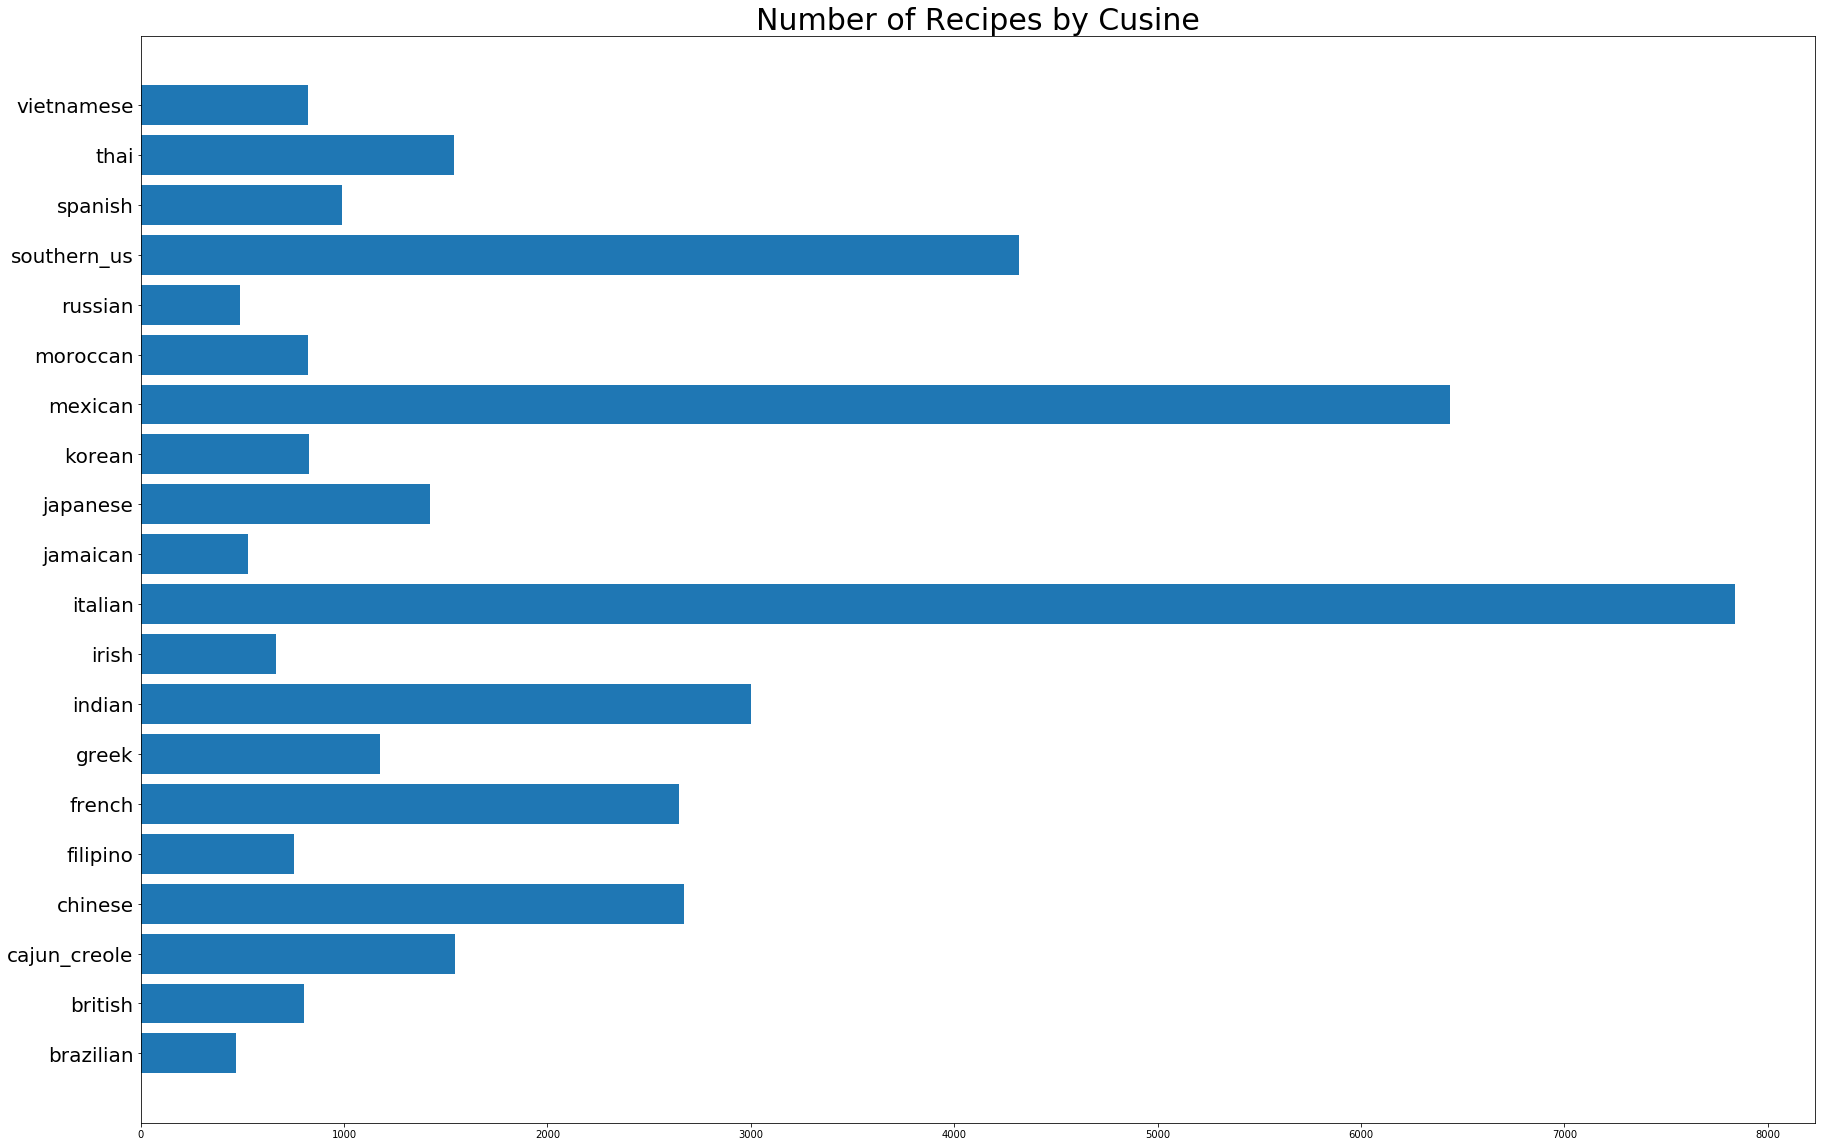

In [24]:
plot.figure(1)
plot.figure(figsize = (30,20))
plot.rc('ytick',labelsize=20)
plot.barh(cuisine_dist['cuisine'], cusine_dist['count'])
plot.title('Number of Recipes by Cusine', fontsize = 30)

#plot.rcParams.update({"figure.figsize": [30,20]})
plot.show()
plot.clf()
plot.cla()
plot.close()

The following is the distribution of number of ingredients in each recipe.  There are no recipes with 0 ingredients.  One has 65 which could be an outlier.  We'll keep an eye on it.

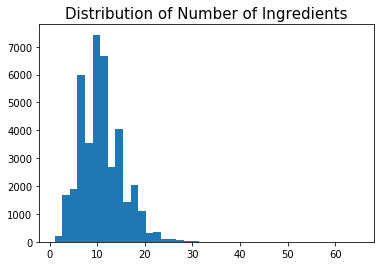

In [26]:
plot.figure(2)
plot.rc('ytick',labelsize=10)
plot.hist(num_ing, bins=40)
plot.title('Distribution of Number of Ingredients', fontsize = 15)
plot.show()

In [27]:
print 'Min num ingredients: ' + str(min(num_ing))
print 'Max num ingredients: ' + str(max(num_ing))

Min num ingredients: 1
Max num ingredients: 65


In general, the data is in the form of a list of terms for each recipe.  The ordering of the ingredients of a recipe likely doesn't affect the cuisine - ingredients are ordered based on the cooking methods or the ingredient type.  So using word embeddings like word2vec, which work well for sentences and paragraph structures, likely won't give us much.  We'll start instead with a simple bag-of-words model, using a multinomial naive bayes classifier. We'll also use weighted F1 score to assess performance, both training and test score.

## Baseline Model

Since many of the ingredients are multiple words - e.g. "purple onion" and "romaine lettuce" - we'll delete the space between multi-word ingredients - e.g. "purpleonion" and "romainelettuce."  Then we'll use CountVectorizer to create the bag of words/ingredients.

In [105]:
# Create bag of words - remove spaces and apostrophes (to prevent token splitting at these places)

docs = [' '.join([x.replace(' ', '').replace("'", "").replace("-", "") for x in y['ingredients']])\
        for y in train_data]
labels = [y['cuisine'] for y in train_data]
vectorizer = CountVectorizer()
bag_words = vectorizer.fit_transform(docs).todense()
vocab = vectorizer.vocabulary_

Next we split the given training set into a separate train and test set, using a 75-25 stratified split. (stratified since the classes are imbalanced)

In [106]:
# Split into new training and test test, using stratified sampling

X_train, X_test, y_train, y_test = train_test_split(bag_words, labels,
                                                    stratify=labels, 
                                                    test_size=0.25)

Next we fit a Naive Bayes model which is a common algorithm used for text classification in conjungtion with a bag-of-words.  This model is very low complexity so its unlikely to overfit.  Still, we'll look at the both the training and testing score:

In [107]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
lab_order = np.unique(labels)

print 'training score: ' + str(f1_score(y_train, y_train_pred, average = 'weighted', labels = lab_order))
print 'test score: ' + str(f1_score(y_test, y_pred, average = 'weighted', labels = lab_order))

training score: 0.759291761664542
test score: 0.7153631444361395


The performance of this model isn't amazing, but its a good starting point.  We'll look at a confusion matrix, but with the rows normalized, to get an idea of the distribution of miss-classified samples. (shown below)  

In [157]:
mat = confusion_matrix(y_pred, y_test, labels = lab_order)
norm_conf = pd.DataFrame(mat).div(pd.DataFrame(mat).sum(axis=1), axis=0) * 100.0
norm_conf.columns = lab_order
norm_conf.index = lab_order

In [159]:
from sklearn.metrics import f1_score
df = pd.DataFrame({'accuracy': f1_score(y_test, y_pred, average = None, labels = lab_order)})
df.index = lab_order
df = pd.concat([df, norm_conf], 1)

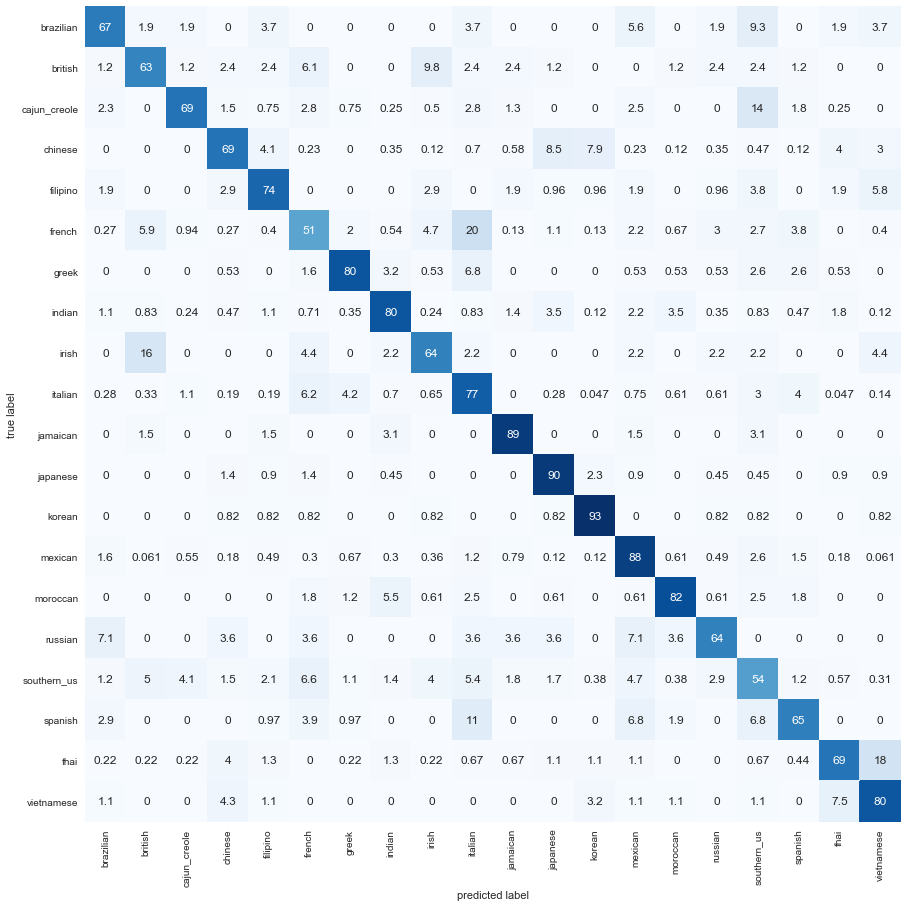

In [167]:
plot.figure(3, figsize = (15,15))
sns.heatmap(norm_conf, square=True, annot=True, cbar=False, cmap = "Blues",
           xticklabels = lab_order, yticklabels = lab_order)
plot.ylabel('true label')
plot.xlabel('predicted label');
plot.show()

The main "mix-ups" are:

1. 9.8% of "British" miss-classified as "Irish"
2. 14% of "Cajon Creole" miss-classified as "Southern US"
3. 8.5% and 7.9% of "Chinese" miss-classified as "Japanese" and "Korean" respectively
4. 20% of "French" miss-classified as "Italian"
5. 16% of "Irish" miss-classified as "British"
6. 7.1% of "Russian" miss-classified as "Brazilian" and "Mexican"
7. 5%, 6.6% and 5.4% of "Southern US" miss-classified as "British", "French" and "Italian" respectively
8. 11%, 6.8% and 6.8% of "Spanish" miss-classified as "Italian", "Mexian" and "Southern US" respectively
9. 18% of "Thai" miss-classified" as "Vietnamese"

A lot of these make sense since, for example, Thai and Vietnamese cuisines are quite similar in some respects and thus use similar ingredients.

We can also look at the top/bottom predictive 'features' or words for each class.  Below are the top 10 words for each cusine, and the top bottom words:

In [99]:
top_feats_cuisine = dict(zip(np.sort(lab_order),
                            [list(pd.DataFrame(zip(vectorizer.get_feature_names(), x))\
                             .sort_values(1, ascending = False).iloc[range(10), 0]) for x in clf.coef_]))
pd.DataFrame(top_feats_cuisine).T

,0,1,2,3,4,5,6,7,8,9
brazilian,salt,onions,oliveoil,lime,water,garlic,garliccloves,cachaca,sugar,coconutmilk
british,salt,purposeflour,all,butter,milk,unsaltedbutter,sugar,eggs,onions,bakingpowder
cajun_creole,salt,onions,garlic,butter,greenbellpepper,oliveoil,cajunseasoning,water,purposeflour,all
chinese,soysauce,sesameoil,cornstarch,salt,sugar,garlic,water,greenonions,vegetableoil,scallions
filipino,salt,garlic,onions,water,soysauce,pepper,oil,sugar,groundblackpepper,carrots
french,salt,sugar,unsaltedbutter,all,purposeflour,butter,oliveoil,water,garliccloves,largeeggs
greek,salt,oliveoil,driedoregano,fetacheesecrumbles,garliccloves,virginoliveoil,extra,freshlemonjuice,groundblackpepper,garlic
indian,salt,onions,garammasala,water,groundturmeric,garlic,cuminseed,groundcumin,oil,vegetableoil
irish,salt,all,purposeflour,butter,onions,bakingsoda,potatoes,bakingpowder,sugar,carrots
italian,salt,oliveoil,garliccloves,gratedparmesancheese,garlic,groundblackpepper,extra,virginoliveoil,onions,water


In [100]:
bot_feats_cuisine = dict(zip(np.sort(lab_order),
                            [list(pd.DataFrame(zip(vectorizer.get_feature_names(), x))\
                             .sort_values(1).iloc[range(10), 0]) for x in clf.coef_]))
pd.DataFrame(bot_feats_cuisine).T

,0,1,2,3,4,5,6,7,8,9
brazilian,10oz,parmagianoreggiano,parevemargarine,parboiledrice,paratha,pappardellepasta,pappardelle,pappadams,papalo,papad
british,10oz,oysters,oystermushrooms,oysterliquor,oyster,oxtongue,oxtails,oven,ouzo,othervegetables
cajun_creole,10oz,olivpitripe,olivetapenade,oliveoilspray,oliveoilmayonnaise,oleo,oldginger,oldfashionedstonegroundgrits,oldelpasotacoseasoningmix,oldelpasogreenchiles
chinese,10oz,nonfatplaingreekyogurt,nonfatmozzarellacheese,nonfatmilkpowder,nonfatmilk,nonfatmayonnaise,nonfatitaliandressing,nonfathalf,nonfatgreekyogurt,nonfatfrozenyogurt
filipino,10oz,pangasius,panettone,panela,paneercheese,paneer,panedicasa,pandrippings,pandanessence,pancit
french,10oz,napacabbage,namprik,nampla,namashoyu,nakanoseasonedricevinegar,nachochips,nachocheesetortillachips,naan,napacabbageleaves
greek,10oz,oxtails,oven,othervegetables,other,osetracaviar,oscarmayerdelifreshsmokedham,oscarmayercottosalami,oscarmayerbacon,ortegatostadashells
indian,10oz,oliveoilcookingspray,oleo,oldginger,oldfashionedstonegroundgrits,oldelpasotacoseasoningmix,oldelpasogreenchiles,oldelpasoflourtortillas,oldelpasoenchiladasauce,oldelpaso
irish,10oz,panettone,panela,paneercheese,paneer,panedicasa,pandrippings,pandanusleaf,pandanextract,pandanessence
italian,kipperedherringfillets,groundchile,groundchipotlechilepepper,roastedpepitas,roastedpeanuts,roastedgroundcumin,groundcoffee,roastedgarlicoil,roastedchilipaste,roastedchestnuts


In turns out that salt, soy sauce and fish sauce are the top predictive words - as if the ingredient that gives a dish sodium, is indicative of the cuisine.  We can also see why certain recipes are misclassified - for example thai and vietnamese cuisines have many of the same top ingredients.

There are some weird words showing up in the top words - like "all" which doesn't seem to be an ingredient.  This could be contributing to the miss-classifications.  Also, some preprocessing could be done to merge features together - like "butter" and "unsaltedbutter"

The bottom ingredients also indicate that some further data cleaning is needed.  There are volume measurements that should be removed.  Also brand-specific ingredients like "knorr beef stock cubes" and "mountain dew soda" that need to be processed to remove the branding.

## Preprocessing

We'll apply the following preprocessing:

1. Remove 'accent' codes, such as in non-english words. (E.g. Convert 'tomato pur\xe9e' to 'tomato puree')
2. Identify Branding words, assess effect on classification, and potentially remove
3. Correct misspellings
4. Identify potential ingredient groupings - i.e. ingredients that can merged into a single ingredient

### Removing accents

In [14]:
words = [y['ingredients'] for y in train_data]
words = [item for sublist in words for item in sublist]

The following shows the words with accent codes and their corrected form

In [56]:
pd.DataFrame([(x, unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore')) for x in words if '\\' in "%r"%x])

,0,1
0,pumpkin purée,pumpkin puree
1,kahlúa,kahlua
2,kahlúa,kahlua
3,kahlúa,kahlua
4,grated Gruyère cheese,grated Gruyere cheese
5,tomato purée,tomato puree
6,Bertolli® Classico Olive Oil,Bertolli Classico Olive Oil
7,Old El Paso™ mild red enchilada sauce,Old El PasoTM mild red enchilada sauce
8,Pillsbury™ Refrigerated Crescent Dinner Rolls,PillsburyTM Refrigerated Crescent Dinner Rolls
9,crème fraîche,creme fraiche


In [61]:
# Actually correct in the training data
def remove_accents(recipe):
    clean_recipe = copy.deepcopy(recipe)
    clean_recipe['ingredients'] = [unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore')\
                                   for x in recipe['ingredients']]
    return clean_recipe
train_data_clean = [remove_accents(x) for x in train_data]

### Branding Analysis

To find ingredients with potential branding, we'll look for those containing capital letters.  Then we'll take the most common ones and look at their class distributions.

In [129]:
# Use a count vectorizer without lower case conversion and simple splitting based on spaces to get word occurrences

def my_tokenizer(doc):
    return (doc.split(' '))

docs = [' '.join([x.replace(' ', '').replace("'", '').replace("-", "") for x in y['ingredients']]) for y in train_data_clean]
labels = [y['cuisine'] for y in train_data_clean]
vectorizer = CountVectorizer(lowercase = False, tokenizer = my_tokenizer)
bag_words = vectorizer.fit_transform(docs).todense()

In [130]:
import operator
sort_ing = sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))
ing_cap = [x for x in sort_ing if (isinstance(x[0], basestring)) and (any(s.isupper() for s in x[0]))]

In [131]:
ing_cap_occ = pd.DataFrame(bag_words[:, [x[1] for x in ing_cap]], columns = [x[0] for x in ing_cap])

In [133]:
ing_cat_order = ing_cap_occ.sum().sort_values(ascending = False).iloc[0:50]
ing_cat_order

shreddedMontereyJackcheese         314
Sriracha                           298
Shaoxingwine                       264
TabascoPepperSauce                 184
Mexicancheeseblend                 174
Gochujangbase                      142
Thairedcurrypaste                  127
Italianparsleyleaves               125
Italianbread                       118
Thaifishsauce                      108
Mexicanoregano                     100
Mexicancheese                       68
gratedGruyerecheese                 61
Italianturkeysausage                54
Anaheimchile                        51
Californiabayleaves                 50
Alfredosauce                        48
hotItaliansausages                  48
Chineseeggnoodles                   44
Belgianendive                       38
Madrascurrypowder                   36
Americancheese                      34
Madeira                             33
Irishwhiskey                        31
GrandMarnier                        30
Italianseasonedbreadcrumb

Many of these common ingredients with capital letters don't exactly contain branding - just a name of a country - but that is still a type of branding.  We'll take a couple of the most common ones and compare their class distributions with 'unbranded' versions of them.  Here we'll remove the 'branding' in a naive way by cutting out the proper nouns:

shreddedMontereyJackcheese -> shreddedcheese
Shaoxingwine -> wine
Italianbread -> bread
Thaifishsauce -> fishsauce

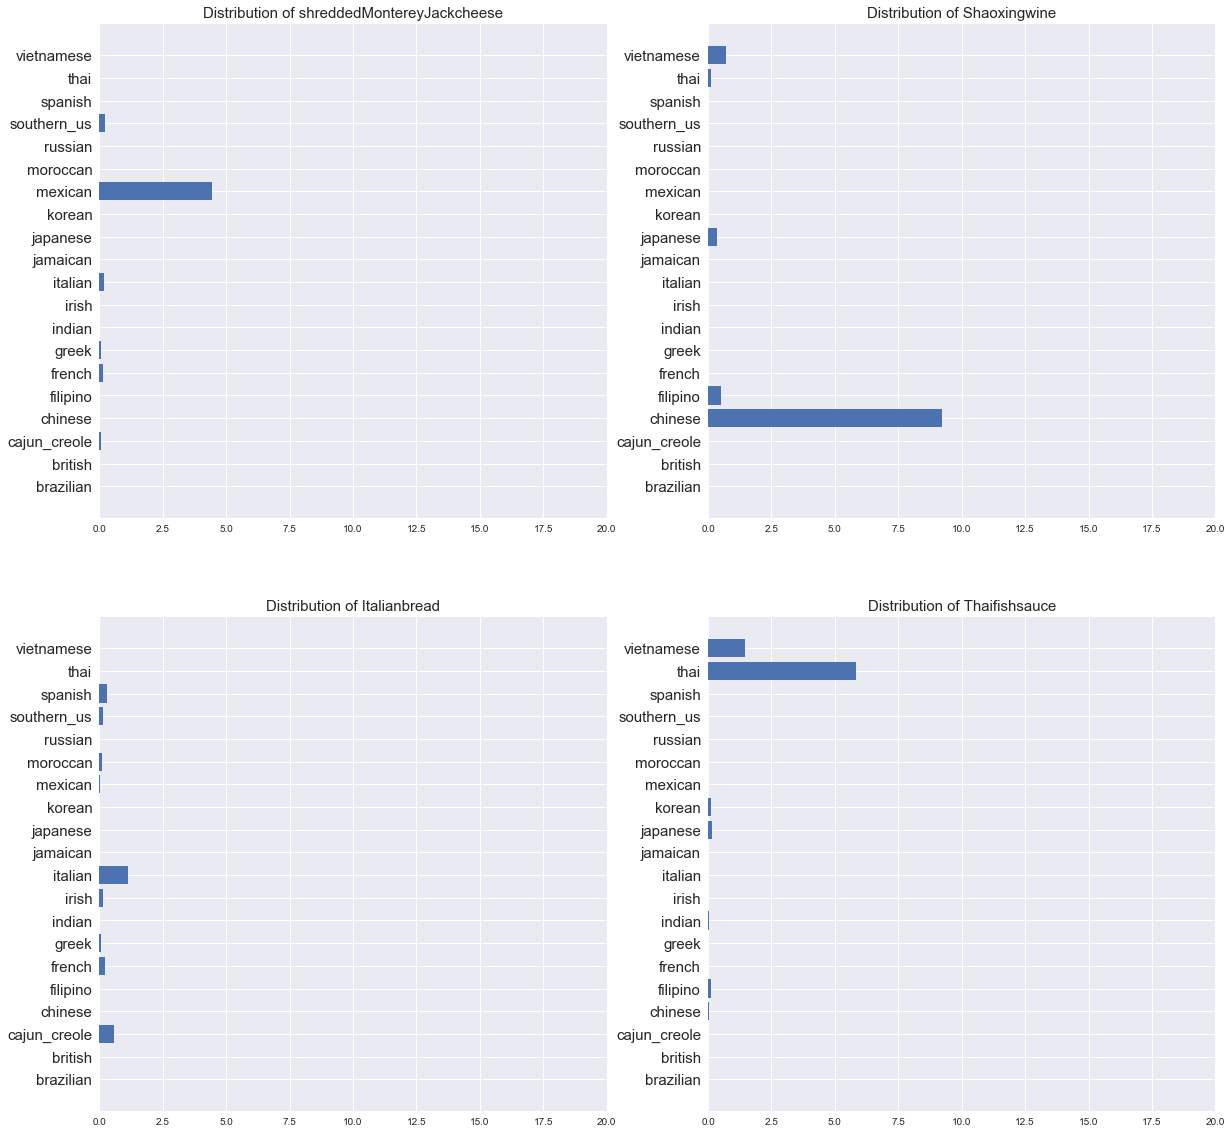

In [185]:
cap_dist = ing_cap_occ.loc[:, ing_cat_order.index].groupby(labels).sum()
for ind in cap_dist.index:
    cap_dist.loc[ind,:] = cap_dist.loc[ind,:] * 100.0 / float(cuisine_dist.loc[cuisine_dist['cuisine']==ind,'count'])

plot.figure(5)
plot.figure(figsize = (20,20))

i = 1
for f in ['shreddedMontereyJackcheese', 'Shaoxingwine', 'Italianbread', 'Thaifishsauce']:

    ax = plot.subplot(2, 2, i)
    ax.set_xlim([0, 20])
    plot.rc('ytick',labelsize=15)
    plot.barh(cap_dist.index, cap_dist[f])
    plot.title('Distribution of ' + f, fontsize = 15)
    i+=1

plot.show()
#plot.clf()
#plot.cla()
#plot.close()

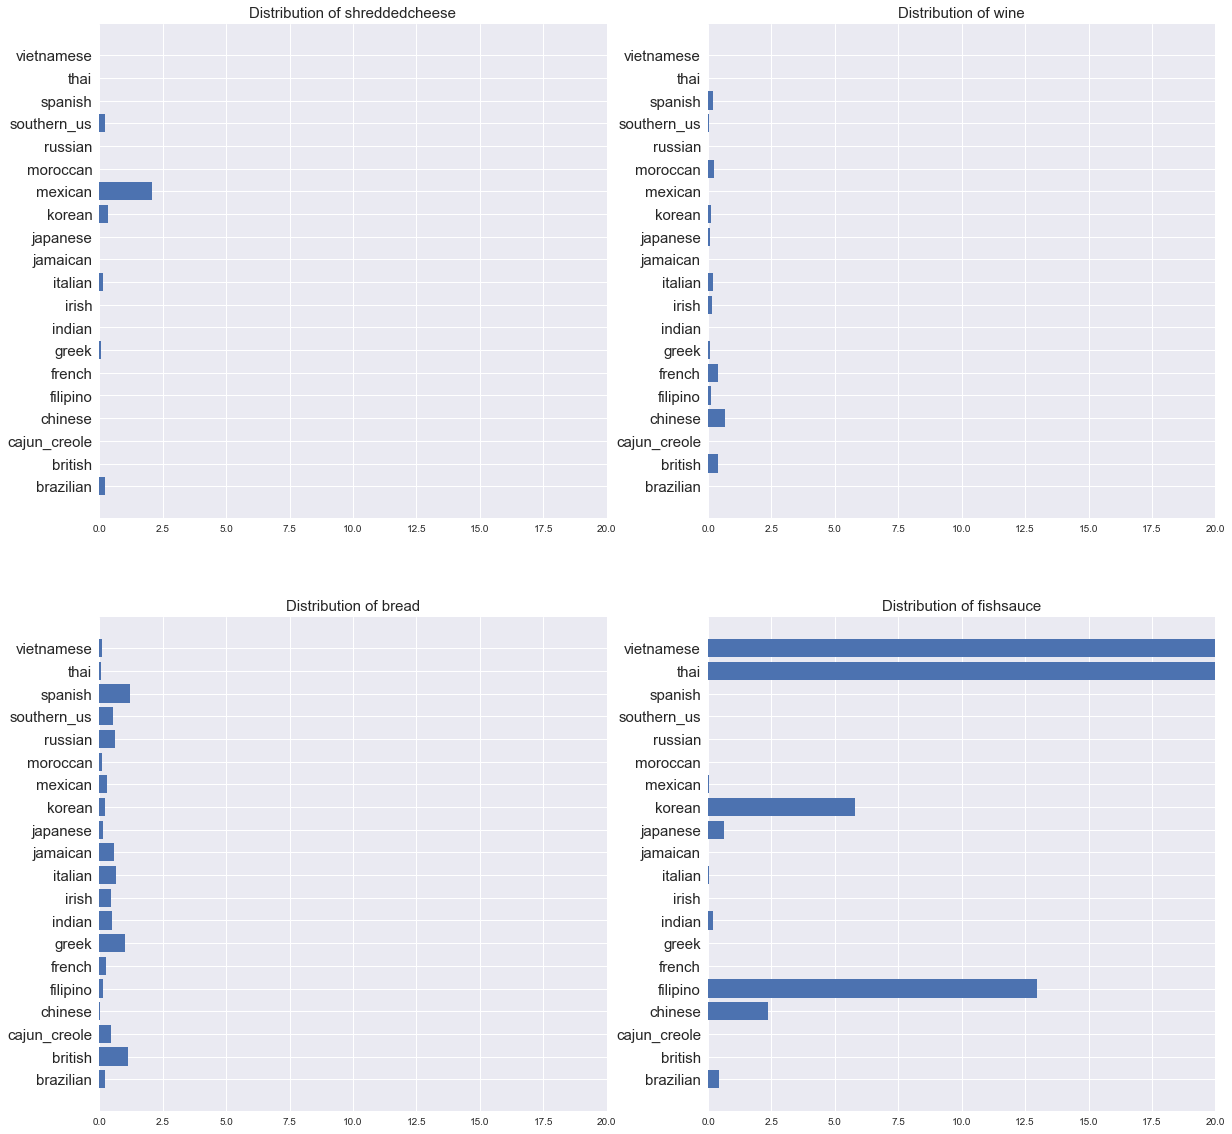

In [188]:
ing = ['shreddedcheese', 'wine', 'bread', 'fishsauce']
df = pd.DataFrame(bag_words[:, [vectorizer.vocabulary_[x] for x in ing]], columns = ing)
df = df.groupby(labels).sum()
for ind in df.index:
    df.loc[ind,:] = df.loc[ind,:] * 100.0 / float(cuisine_dist.loc[cuisine_dist['cuisine']==ind,'count'])
    
plot.figure(6)
plot.figure(figsize = (20,20))

i = 1
for f in ing:

    ax = plot.subplot(2, 2, i)
    ax.set_xlim([0, 20])
    plot.rc('ytick',labelsize=15)
    plot.barh(df.index, df[f])
    plot.title('Distribution of ' + f, fontsize = 15)
    i+=1

For some ingredients, the distributions of the unbranded versions are very difference than the branded versions - mainly for "bread" and "fishsauce."  Removing the branding, at least in a naive way for these ingredients could remove some differentiation between cuisines.  However for other ingredients like "shreddedcheese", removing the branding could add to the differentiation.  We likely need a smart way to deal with the branding issue.